# Electric Vehicules routing

https://azure.microsoft.com/en-us/products/azure-maps/?msockid=2e39c66c693c66a5151fd200687567d0

https://learn.microsoft.com/en-us/azure/azure-maps/

In [1]:
import aiohttp
import urllib.parse
import os
import time
import sys

from dotenv import load_dotenv
from IPython.display import Image, display

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
load_dotenv("azure.env")

subscription_key = os.getenv('AZURE_MAPS_KEY')

## Map

In [4]:
currentLocation = [48.860294, 2.338629]

session = aiohttp.ClientSession()

# Parameters for the vehicle consumption model
travelMode = "car"
vehicleEngineType = "electric"
currentChargeInkWh = 60
maxChargeInkWh = 80
timeBudgetInSec = 550
routeType = "eco"
constantSpeedConsumptionInkWhPerHundredkm = "50,8.2:130,21.3"

# Get boundaries for the electric vehicle's reachable range.
routeRangeResponse = await (await session.get("https://atlas.microsoft.com/route/range/json?subscription-key={}&api-version=1.0&query={}&travelMode={}&vehicleEngineType={}&currentChargeInkWh={}&maxChargeInkWh={}&timeBudgetInSec={}&routeType={}&constantSpeedConsumptionInkWhPerHundredkm={}"
                                              .format(subscription_key, str(currentLocation[0])+","+str(currentLocation[1]), travelMode, vehicleEngineType, currentChargeInkWh, maxChargeInkWh, timeBudgetInSec, routeType, constantSpeedConsumptionInkWhPerHundredkm))).json()

polyBounds = routeRangeResponse["reachableRange"]["boundary"]

for i in range(len(polyBounds)):
    coordList = list(polyBounds[i].values())
    coordList[0], coordList[1] = coordList[1], coordList[0]
    polyBounds[i] = coordList

polyBounds.pop()
polyBounds.append(polyBounds[0])

boundsData = {
    "geometry": {
        "type": "Polygon",
        "coordinates":
        [
            polyBounds
        ]
    }
}

# Search for electric vehicle stations within reachable range.
searchPolyResponse = await (await session.post(url="https://atlas.microsoft.com/search/geometry/json?subscription-key={}&api-version=1.0&query=electric vehicle station&idxSet=POI&limit=10".format(subscription_key), json=boundsData)).json()

reachableLocations = []

for loc in range(len(searchPolyResponse["results"])):
    location = list(searchPolyResponse["results"][loc]["position"].values())
    location[0], location[1] = location[1], location[0]
    reachableLocations.append(location)

# Get boundaries for the bounding box.

def getBounds(polyBounds):
    maxLon = max(map(lambda x: x[0], polyBounds))
    minLon = min(map(lambda x: x[0], polyBounds))
    maxLat = max(map(lambda x: x[1], polyBounds))
    minLat = min(map(lambda x: x[1], polyBounds))

    lonBuffer = (maxLon-minLon)*0.5
    minLon -= lonBuffer
    maxLon += lonBuffer
    latBuffer = (maxLat-minLat)*0.5
    minLat -= latBuffer
    maxLat += latBuffer

    return [minLon, maxLon, minLat, maxLat]


minLon, maxLon, minLat, maxLat = getBounds(polyBounds)
polyBoundsFormatted = ('|'.join(map(str, polyBounds))).replace(
    '[', '').replace(']', '').replace(',', '')
reachableLocationsFormatted = ('|'.join(map(str, reachableLocations))).replace(
    '[', '').replace(']', '').replace(',', '')

path = "lcff3333|lw3|la0.80|fa0.35||{}".format(polyBoundsFormatted)
pins = "custom|an15 53||{}||https://raw.githubusercontent.com/Azure-Samples/AzureMapsCodeSamples/e3a684e7423075129a0857c63011e7cfdda213b7/Static/images/icons/ev_pin.png".format(
    reachableLocationsFormatted)
encodedPins = urllib.parse.quote(pins, safe='')

# Render the range and electric vehicle charging points on the map with maximum size.
staticMapResponse = await session.get("https://atlas.microsoft.com/map/static?api-version=2024-04-01&subscription-key={}&pins={}&path={}&bbox={}&zoom=12&size=512x512".format(subscription_key, encodedPins, path, str(minLon)+", "+str(minLat)+", "+str(maxLon)+", "+str(maxLat)))
poiRangeMap = await staticMapResponse.content.read()

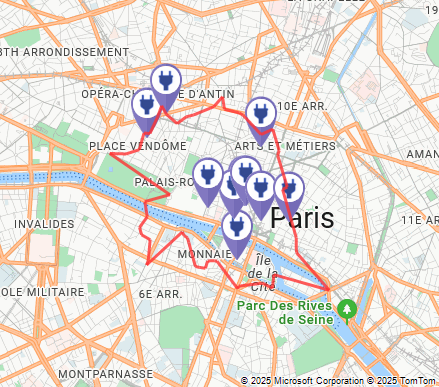

In [5]:
display(Image(poiRangeMap, width=640, height=640))  # Control display size